In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_curve, roc_auc_score

/Users/uyennguyen/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
#Import the data set
df = pd.read_csv('breast-cancer-data.csv.data')

#1. Sample code number: id number 
#2. Clump Thickness: 1-10
#3. Uniformity of Cell Size: 1-10
#4. Uniformity of Cell Shape: 1-10
#5. Marginal Adhesion: 1-10
#6. Single Epithelial Cell Size: 1-10
#7. Bare Nuclei: 1-10
#8. Bland Chromatin: 1-10
#9. Normal Nucleoli: 1-10
#10. Mitoses: 1-10
#11. Class: (2 for benign, 4 for malignant)

In [6]:
#Name the columns of the dataset
df.columns = ['ID','thickness','size','shape','marginal_adhesion',
              'epithelial_size','bare_nuclei','bland_chromatin',
              'normal_nucleoli','mitoses','class']

In [7]:
df.drop('ID',1,inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 10 columns):
thickness            698 non-null int64
size                 698 non-null int64
shape                698 non-null int64
marginal_adhesion    698 non-null int64
epithelial_size      698 non-null int64
bare_nuclei          698 non-null object
bland_chromatin      698 non-null int64
normal_nucleoli      698 non-null int64
mitoses              698 non-null int64
class                698 non-null int64
dtypes: int64(9), object(1)
memory usage: 54.6+ KB


In [9]:
#Run conversion of the bare_nuclei column from string to float and save the rows that can't convert
errors = []
for i in range(df.shape[0]):
    try:
        float(df['bare_nuclei'].iloc[i])
    except ValueError:
        errors.append(i)
print(len(errors))

16


In [10]:
#Remove these erroneous rows, since there are only 16 of them
#this shouldn't affect the data size 
df_cleaned = df.drop(df.index[errors])

#Convert bare_nuclei column from string to float
df_cleaned['bare_nuclei']=df_cleaned['bare_nuclei'].apply(lambda x:float(x))

In [11]:
df_cleaned['class'].value_counts()

2    443
4    239
Name: class, dtype: int64

### Logics
From this pairplot below, it appears that there are a distinct ditribution pattern of all feature between the two classes of cells.
Therefore, all of these features are important and thus used to determine cell classes.

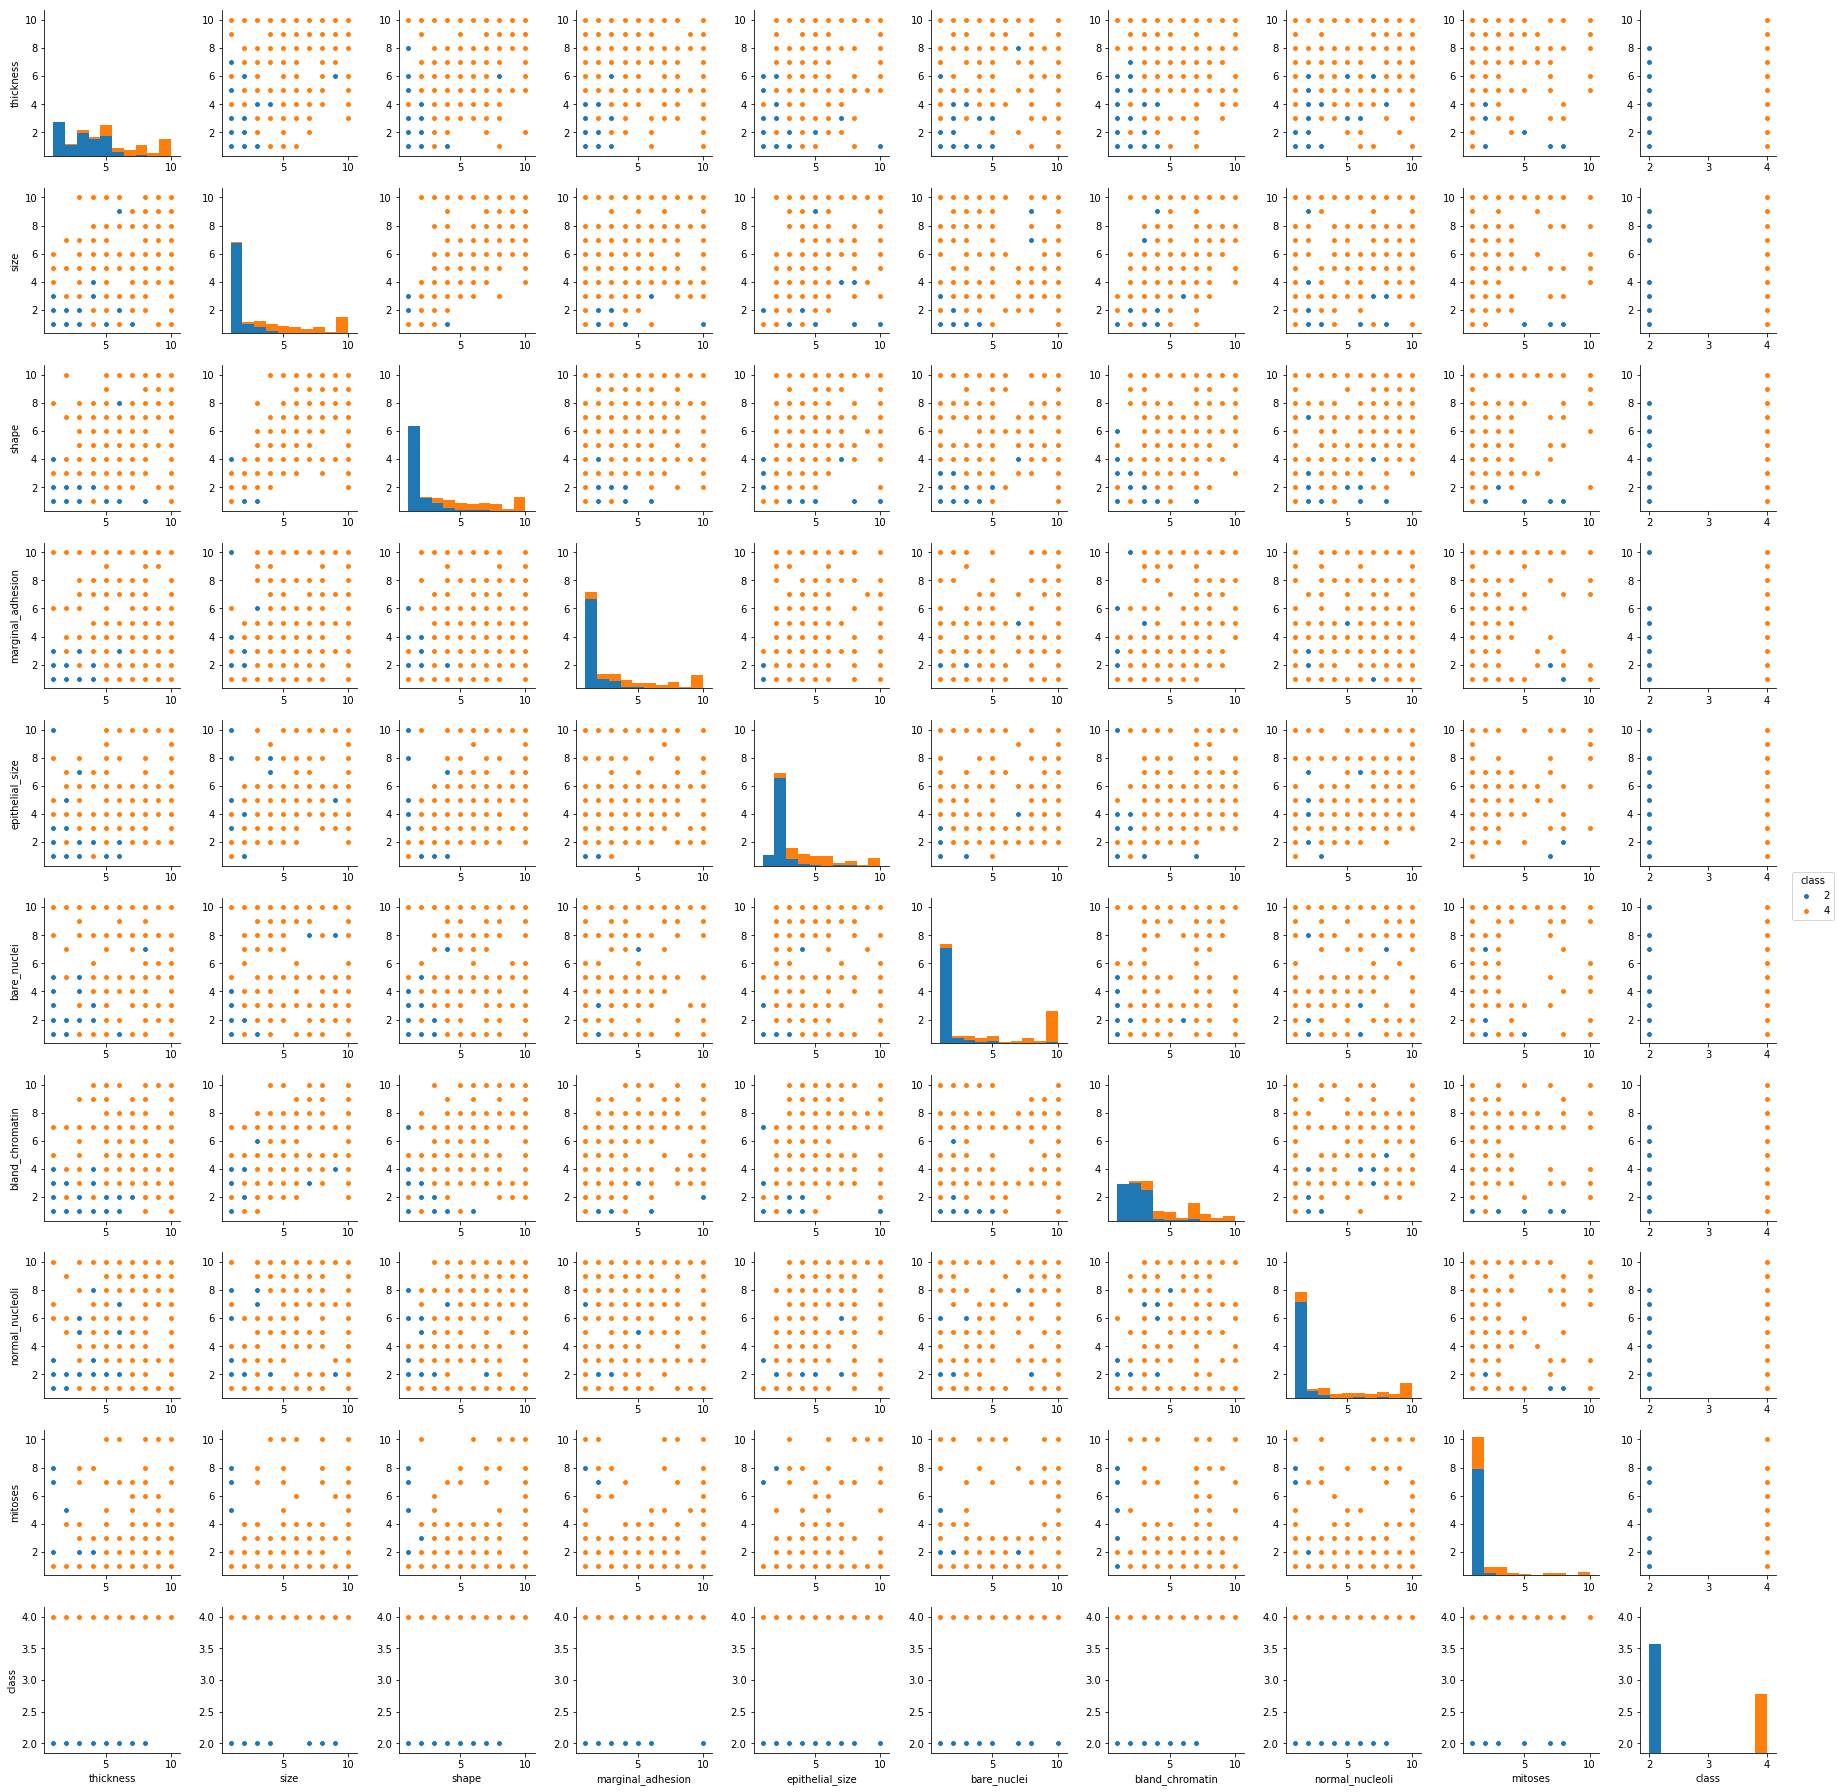

In [12]:
sns.pairplot(data = df_cleaned,hue='class')

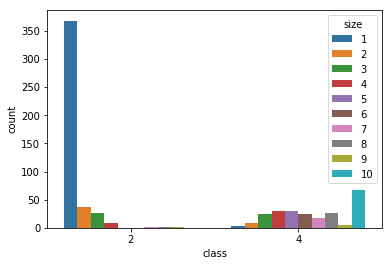

In [13]:
sns.countplot(x='class',hue='size',data=df_cleaned)

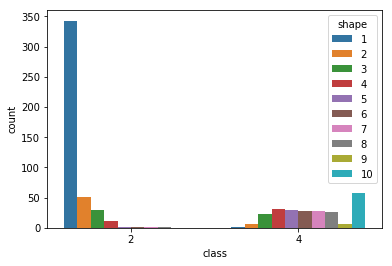

In [54]:
sns.countplot(x='class',hue='shape',data=df_cleaned)

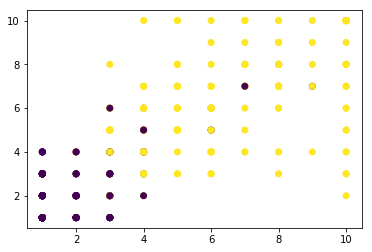

In [14]:
plt.scatter(x=df['size'],y=df['shape'],c=df['class'])

### Below are multiple approaches to tackle this problem
These include logistic regression (simplest approach), PCA+Logistic regression, and SVM. 
All of these models produced relatively good and comparable results for predicting both classes, based on the confusion matrices and classification metrics.

In [40]:
#Split data to train and test
X = df_cleaned.drop('class',1)
y = np.ravel(df_cleaned['class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=101)

# Train a logistic regression model

In [41]:
model_LR = LogisticRegression()
model_LR.fit(X_train,y_train)
y_pred_LR = model_LR.predict(X_test)
print("Confusion matrix","\n", confusion_matrix(y_test,y_pred_LR))
print('\n')
print("Classification report", "\n",classification_report(y_test,y_pred_LR))

Confusion matrix 
 [[112   1]
 [  6  52]]


Classification report 
              precision    recall  f1-score   support

          2       0.95      0.99      0.97       113
          4       0.98      0.90      0.94        58

avg / total       0.96      0.96      0.96       171



In [42]:
def binarize(arr):
    """
    Convert continous valued array to binary. 
    """
    arr[arr == 2] = 0
    arr[arr == 4] = 1
    return arr

In [43]:
y_pred_binary = binarize(y_pred_LR)
y_test_binary = binarize(y_test)
auc_score = roc_auc_score(y_test_binary, y_pred_binary)
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_binary)

ROC_AUC 0.943851083308


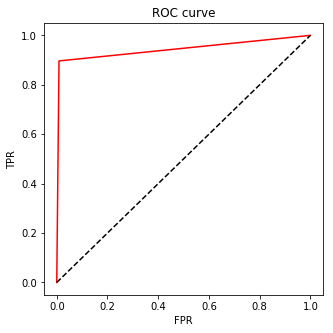

In [44]:
#Plot the ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr,'r')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
print("ROC_AUC", auc_score)

# Train a SVM model

In [45]:
#Split data to train and test
X = df_cleaned.drop('class',1)
y = np.ravel(df_cleaned['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=101)
#Train SVM model
model_SVC = SVC()
model_SVC.fit(X_train,y_train)
y_pred = model_SVC.predict(X_test)

In [46]:
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

[[107   6]
 [  0  58]]


             precision    recall  f1-score   support

          2       1.00      0.95      0.97       113
          4       0.91      1.00      0.95        58

avg / total       0.97      0.96      0.97       171



# Visualize with PCA and applied Logistic Regression on PCA results

Text(0,0.5,'Second Principal Component')

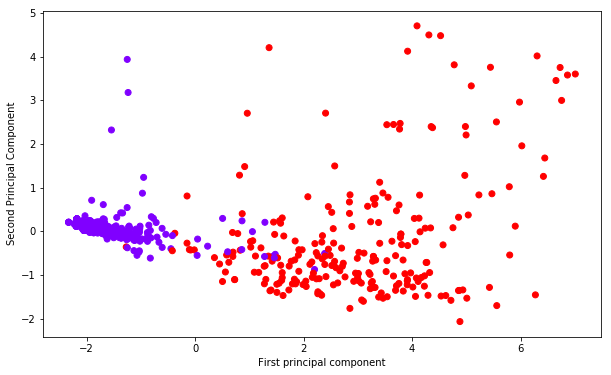

In [47]:
#Visualize with PCA
scaler = StandardScaler()
scaler.fit(df_cleaned.drop('class',1))
scaled_data = scaler.transform(df_cleaned.drop('class',1))
pca = PCA(n_components=2)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)
plt.figure(figsize=(10,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=np.array(df_cleaned['class']),cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [48]:
df_comp = pd.DataFrame(pca.components_,columns=X.columns)

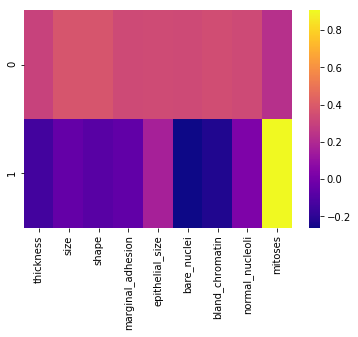

In [49]:
#Heatmap showing the correlation of each feature to the two principal components
sns.heatmap(df_comp,cmap='plasma')
#Again this heatmap shows that all of the available features are relatively important in separating the two classes.

In [50]:
#Create new dataframe with columns of the two PCA components and class column
df_PCA = pd.DataFrame(columns=['PCA1','PCA2'])
df_PCA['PCA1'] = x_pca[:,0]
df_PCA['PCA2'] = x_pca[:,1]

In [51]:
X_PCA = df_PCA
y = np.ravel(df_cleaned['class'])

X_PCA_train, X_PCA_test, y_PCA_train, y_PCA_test = train_test_split(X_PCA, y, test_size=0.25)

In [52]:
model_LR_PCA = LogisticRegression()
model_LR_PCA.fit(X_PCA_train,y_PCA_train)
y_pred_LRPCA = model_LR_PCA.predict(X_PCA_test)

In [53]:
print(confusion_matrix(y_PCA_test,y_pred_LRPCA))
print('\n')
print(classification_report(y_PCA_test,y_pred_LRPCA))

[[106   3]
 [  1  61]]


             precision    recall  f1-score   support

          2       0.99      0.97      0.98       109
          4       0.95      0.98      0.97        62

avg / total       0.98      0.98      0.98       171

